# Data Set: X-ray CCD Observation

Modern X-ray CCDs are technologically to the CCDs used in optical astronomy. The main practical difference is that X-ray photons are rarer and their energies much higher.

This means
* If we read out the CCD every few seconds, only for exceptionally bright sources will we ever have $>1$ photon hit a given pixel.
* We no longer get 1 electron count per photon. Instead the number of counts is proportional to photon energy, which means that these imaging devices are actually imaging spectrometers.
* When we say "counts" in this context, we mean "pixel activation events" rather than electrons trapped, so that (as in optical astronomy) we're referring to the number of photons detected.

Let's look at some processed data from XMM-Newton for galaxy cluster Abell 1835.

Here the raw "event list" has been processed to form an image, so the spectral information has been discarded.

XMM actually has 3 CCD cameras, but we'll just work with 1 for simplicity.

We'll still need 2 files
* the image, in units of counts
* the exposure map (units of seconds), which accounts for the exposure time and the variation in effective collecting area across the field due to shadowing

In [14]:
import astropy.io.fits as pyfits
import numpy as np
datadir = '../data/a1835_xmm/'
imagefile = datadir + 'P0098010101M2U009IMAGE_3000.FTZ'
expmapfile = datadir + 'P0098010101M2U009EXPMAP3000.FTZ'

imfits = pyfits.open(imagefile)
exfits = pyfits.open(expmapfile)

Let's see what we've got

In [15]:
imfits.info()
exfits.info()

Filename: ../data/a1835_xmm/P0098010101M2U009IMAGE_3000.FTZ
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     262   (648, 648)   int32   
  1  GTI00006    BinTableHDU     29   15R x 2C   [D, D]   
  2  GTI00106    BinTableHDU     29   15R x 2C   [D, D]   
  3  GTI00206    BinTableHDU     29   16R x 2C   [D, D]   
  4  GTI00306    BinTableHDU     29   15R x 2C   [D, D]   
  5  GTI00406    BinTableHDU     29   15R x 2C   [D, D]   
  6  GTI00506    BinTableHDU     29   15R x 2C   [D, D]   
  7  GTI00606    BinTableHDU     29   15R x 2C   [D, D]   
Filename: ../data/a1835_xmm/P0098010101M2U009EXPMAP3000.FTZ
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      63   (648, 648)   float32   


`imfits` is a FITS object, containing multiple data structures. The image itself is an array of integer type, and size 648x648 pixels, stored in the primary "header data unit" or HDU. `exfits` contains only the exposure map.

In [16]:
im = imfits[0].data
ex = exfits[0].data
print(im.shape, im.dtype)
print(ex.shape, ex.dtype)

((648, 648), dtype('>i4'))
((648, 648), dtype('>f4'))


> If we need `im` to be floating point for some reason, we would need to cast it, as in `im = imfits[0].data.astype('np.float32')`.

Let's display the image and exposure map

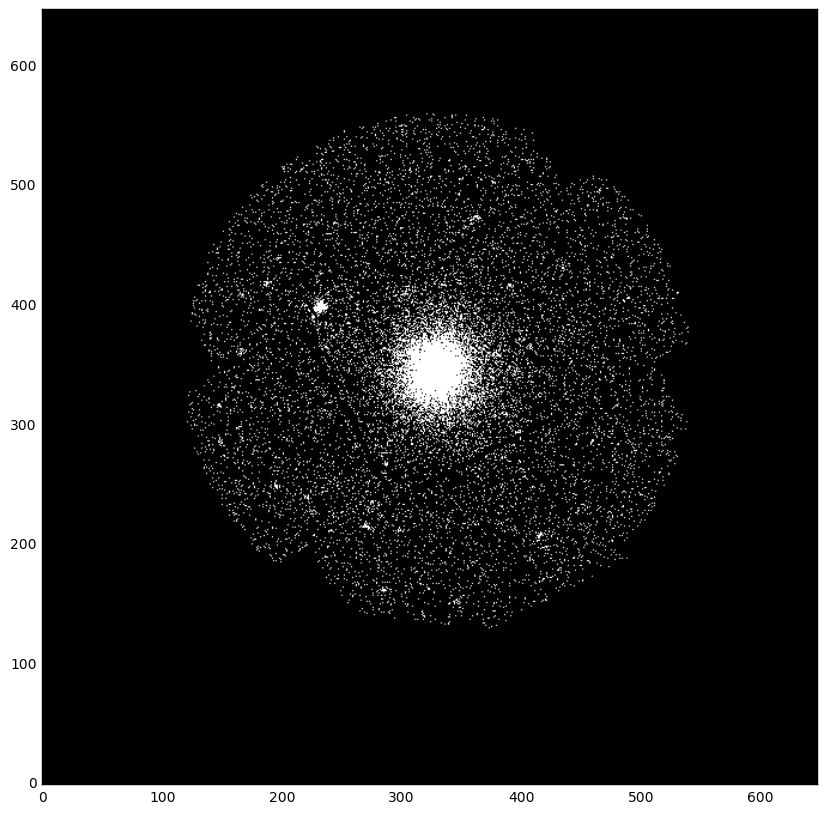

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
from astropy.visualization import LogStretch
logstretch = LogStretch()
plt.imshow(logstretch(im), cmap='gray', origin='lower');

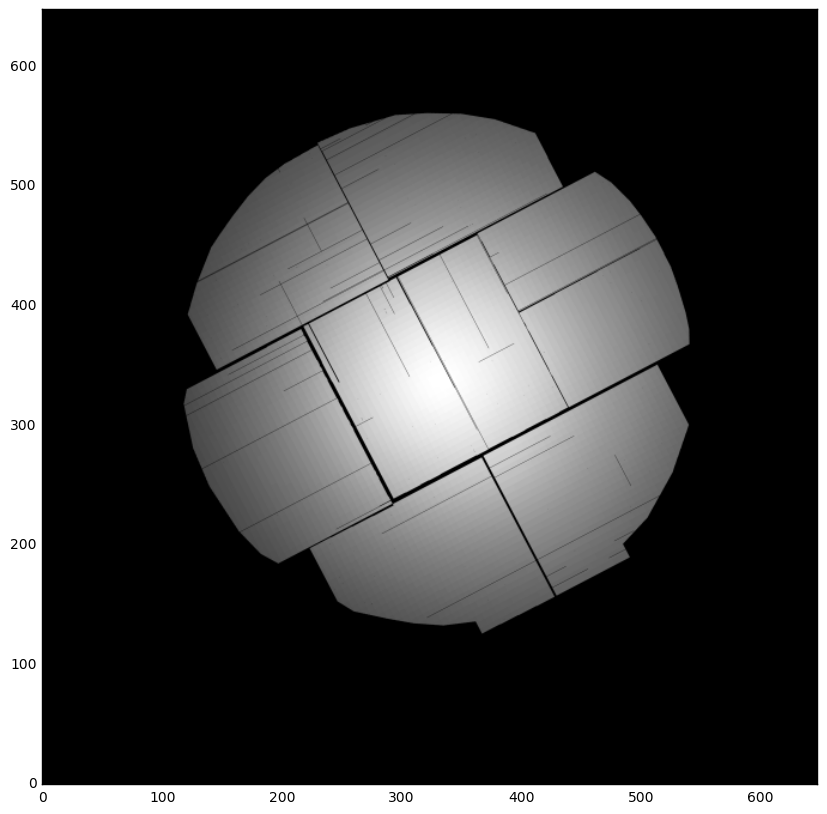

In [18]:
plt.imshow(ex, cmap='gray', origin='lower');

**Note**: FITS images (and the arrays we read from them) are indexed according to the ancient Fortran convention, with the first index corresponding to y (line) and the second index corresponding to x (sample). `pyplot` knows about this, although we *still* need to use `origin='lower'` to display the image the right way up.

In the image, we can see
1. Abell 1835 (the big blob)
2. various other sources (smaller blobs). These are point sources (AGN) that have been smeared out by the point spread function.
3. a roughly uniform background, consisting of unresolved AGN, diffuse X-rays from the Galactic halo and local bubble,  and events due to particles (solar wind protons and cosmic rays) interacting with the CCD

Note that astrophysical X-rays are focussed through the telescope optics, so the vignetting pattern in the exposure map is imprinted on them. The particle background, which makes a significant contribution to the total, is not vignetted.

If we're interested only in the cluster, we can make our lives slightly easier by masking out the other sources. It will be convinient to carry around a "mask image" of 0's and 1's indicating which pixels we should be paying attention to.

It's also useful, if slightly wasteful, to define arrays of the x and y coordinates of each pixel.

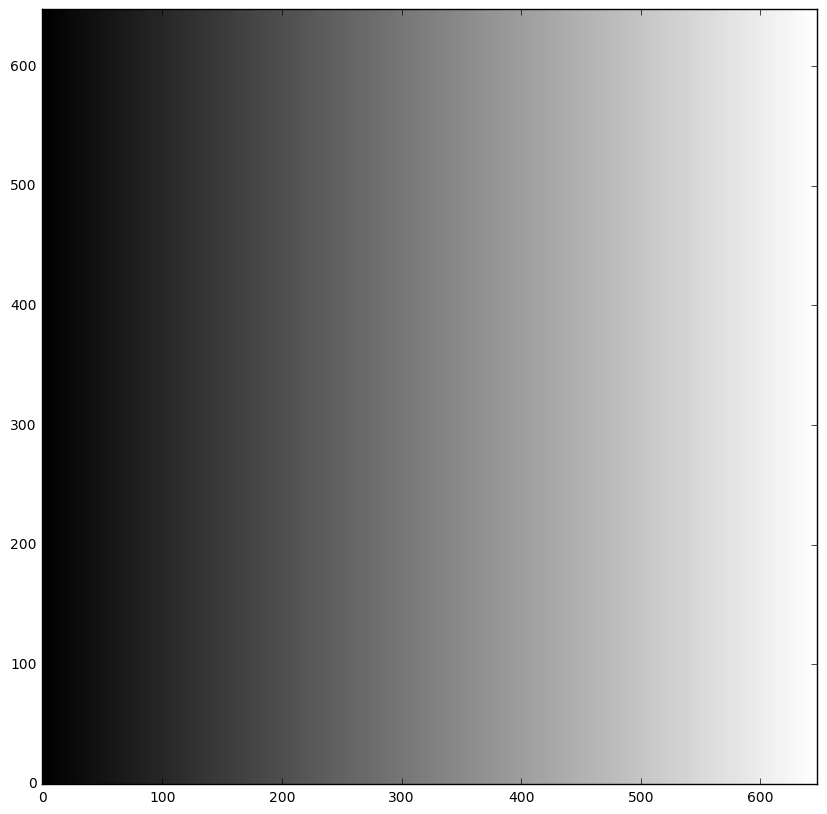

In [19]:
nx,ny = im.shape
xs = np.outer(np.ones(ny),np.arange(nx))
ys = np.outer(np.arange(ny),np.ones(nx))
plt.imshow(xs, cmap='gray', origin='lower');

A list of circular (`x y radius`) regions to mask is saved in a text file. Positions are given in *image coordinates*, i.e. pixels counted from 1 (not from 0).

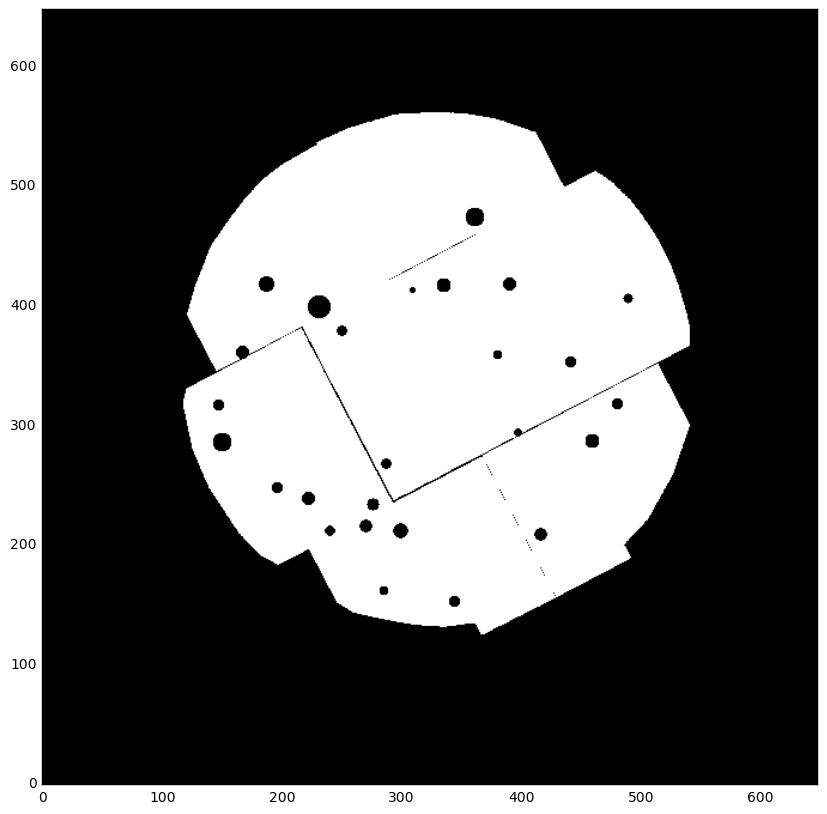

In [20]:
mask = ex * 0.0
mask[ex > 0.0] = 1.0 # notice only illuminated pixels
regions = np.loadtxt(datadir + 'M2ptsrc.txt')
for reg in regions:
    distance2 = (xs-(reg[0]-1.0))**2 + (ys-(reg[1]-1.0))**2
    mask[distance2 <= reg[2]**2] = 0.0

plt.imshow(mask, cmap='gray', origin='lower');

A model for extended emission from the cluster would be given to us in terms of surface brightness, $S$. This has units of counts/(time\*area\*solid angle).

Multiplying by the exposure map would turn this into counts/(solid angle), apart from an overall normalization of the effective area.

In other words, if `CL` is an array made by evaluating $S(x,y)$, then `CL*ex` is a counts image, just like `im` (counts/pixel, pixel being an acceptable unit of solid angle).

In practice, we would also want to account for the (vignetted) astrophysical background and the (unvignetted) particle background, the latter of which should *not* be scaled by the exposure map. We would actually want to compare `(CL+ABG)*ex+PBG` to `im`, where `ABG` is the astrophysical bacground in surface brightness units, and `PBG` is the particle background in counts/second.

(We also need to remember to account for the `mask` image, in practice.)

Ok! That should be enough introduction to get you working on inference using this data set.